In [1]:
import tensorflow as tf
from tensorflow.keras import layers as L
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import os
import numpy as np
import gc
from scipy.stats import norm
import sys
import datetime
sns.set()
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
sys.path.insert(0, '../')
from utils.utils import load_n_samples, AEDatagenerator

# Some major settings

In [22]:
training = True
load = False
use_dropout = False
warm_start = True
model_std = False

In [23]:
date = str(datetime.datetime.now()).split(' ')[0]

In [24]:
additional = ''
if use_dropout:
    additional+='_dropout'
if warm_start:
    additional+='_warm_start'
if model_std:
    additional+='_modeling_std'
if additional:
    name_dec = '../models/vae_dec{0}_{1}.h5'.format(additional,date)
    name_enc = '../models/vae_enc{0}_{1}.h5'.format(additional,date)
    name_vae = '../models/vae{0}_{1}.h5'.format(additional,date)
else:
    name_dec = '../models/vae_dec.h5'
    name_enc = '../models/vae_enc.h5'
    name_vae = '../models/vae.h5'

In [25]:
weights_vae = '../models/vae_dropout_warm_start_2020-07-12.h5'
weights_encoder = ''
weights_decoder = ''

# Loading data

In [26]:
abs_path = 'data/cropped/'
files = os.listdir(abs_path)
files = list(map(lambda x: os.path.join(abs_path, x), files))

In [27]:
train_path, test_path = train_test_split(files,test_size=0.15)

In [28]:
len(train_path), len(test_path)

(54033, 9536)

In [29]:
data = load_n_samples(abs_path=abs_path,samples=1000,workers=2)

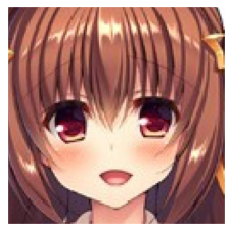

In [30]:
plt.imshow(data[2])
plt.xticks([])
plt.yticks([]);

# Training VAE

In [31]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [32]:
def sample(args):
    t_mean, t_log_var = args
    shape = tf.shape(t_mean)
    eps = tf.random.normal(
    shape=shape)
    return t_mean+eps*tf.exp(0.5*t_log_var)

def create_encoder(input_shape,code_size, use_dropout=False):
        encoder = tf.keras.models.Sequential(name='encoder')
        encoder.add(L.InputLayer(input_shape))
        encoder.add(L.Conv2D(filters=16,kernel_size=(3,3),padding='same',activation='elu'))
        encoder.add(L.MaxPool2D())
        encoder.add(L.Conv2D(filters=32,kernel_size=(3,3),padding='same',activation='elu'))
        encoder.add(L.MaxPool2D())
        encoder.add(L.Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='elu'))
        encoder.add(L.MaxPool2D())
        encoder.add(L.Conv2D(filters=128,kernel_size=(3,3),padding='same',activation='elu'))
        encoder.add(L.MaxPool2D())
        encoder.add(L.Conv2D(filters=256,kernel_size=(3,3),padding='same',activation='elu'))
        encoder.add(L.MaxPool2D())
        encoder.add(L.Conv2D(filters=512,kernel_size=(3,3),padding='same',activation='elu'))
        encoder.add(L.MaxPool2D())
        encoder.add(L.Flatten())
        if use_dropout:
            encoder.add(L.Dropout(0.2))
        encoder.add(L.Dense(units=code_size,activation='elu'))
        print(encoder.summary())
        return encoder 

def create_decoder(code_size,use_dropout=True):
        decoder = tf.keras.models.Sequential(name='decoder')
        decoder.add(L.InputLayer((code_size,)))
        decoder.add(L.Dense(2*2*512,activation='elu'))
        if use_dropout:
            decoder.add(L.Dropout(0.2))
        decoder.add(L.Reshape(target_shape=(2,2,512)))
        decoder.add(L.Conv2DTranspose(filters=1024, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
        decoder.add(L.Conv2DTranspose(filters=512, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
        decoder.add(L.Conv2DTranspose(filters=256, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
        decoder.add(L.Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
        decoder.add(L.Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
        decoder.add(L.Conv2DTranspose(filters=3, kernel_size=(3, 3), strides=2, activation='sigmoid', padding='same'))
        print(decoder.summary())
        return decoder


In [38]:
batch_size = 128
original_dim = (128,128,3)
code_size = 64
epochs = 240
x_std = 0.01
var_epsilon = 0.001

In [39]:
def KLwarmup(epoch):
    value = K.get_value(kl_weight)
    if value<1 and (epoch+1)%2==0:
        K.set_value(kl_weight,(epoch+1)/40.0)
        print('\n KL weight value : {}'.format(K.get_value(kl_weight)))
    elif value>1:
        K.set_value(kl_weight,1)

In [40]:
KLweightSchedular = tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch, log: KLwarmup(epoch))

In [41]:
class GenerationVisualizer(tf.keras.callbacks.Callback):
    def __init__(self,data,batch_size=128, per_epoch=5):
        self.data = data
        self.per_epoch = per_epoch
        self.batch_size = batch_size
        
    def on_epoch_end(self, epoch,logs={}):
        if epoch%self.per_epoch==0:
            if not model_std:
                
                generator = [i for i in self.model.layers if i.name=='decoder'][0]
            else:
                input = L.Input((code_size,))
                decoder = [i for i in self.model.layers if i.name=='decoder'][0](input)
                output = self.model.layers[-1](decoder)
                generator = tf.keras.Model(inputs=input, outputs=output)
            size = 128
            n = 10  
            figure = np.zeros((size * n, size * n,3))

            for i in range(n):
                for j in range(n):
                    z_sample = np.random.normal(size=(1,code_size))
                    x_decoded = generator.predict(z_sample)
                    anime_face = x_decoded[0].reshape(size, size,3)
                    x = i * size
                    y = j * size
                    figure[x:x + size, y:y + size] = anime_face

            plt.figure(figsize=(14, 14))
            plt.title('Sprite of generated images for epoch : {0}'.format(epoch))
            plt.imshow(figure)
            plt.show()

In [42]:
class ActivationsVisualizer(tf.keras.callbacks.Callback):
    def __init__(self,data,batch_size=128, per_epoch=5):
        self.data = data
        self.per_epoch = per_epoch
        self.batch_size = batch_size
        
    def on_epoch_end(self, epoch,logs={}):
        if epoch%self.per_epoch==0:
            model = tf.keras.Model(inputs=self.model.layers[1].input, outputs=self.model.layers[1].layers[-4].output)
            img = self.data[np.random.choice(self.data.shape[0])]
            feature_maps = model.predict(np.expand_dims(img,axis=0))
            square = 8
            ix = 1
            plt.figure(figsize=(15,12))
            plt.title('Activations of conv layer')
            for _ in range(square):
                for _ in range(square):
                    ax = plt.subplot(square, square, ix)
                    ax.set_xticks([])
                    ax.set_yticks([])
                    plt.imshow(feature_maps[0, :, :, ix-1], cmap='magma')
                    ix += 1
            plt.show()

In [43]:
K.clear_session()
kl_weight = K.variable(0.0)
kl_weight._trainable = False
x = L.Input(batch_shape=(batch_size,*original_dim))
encoder = create_encoder(original_dim,code_size,use_dropout)
if load and weights_encoder:
    encoder.load_weights(weights_encoder)
h = encoder(x)
t_mean = L.Dense(code_size)(h)
t_log_var = L.Dense(code_size)(h)
t = L.Lambda(sample)([t_mean,t_log_var])
decoder = create_decoder(code_size,use_dropout)
if load and weights_decoder and not model_std:
    decoder.load_weights(weights_decoder)
if model_std:
    decoder = tf.keras.Model(decoder.input, decoder.layers[-2].output,name='decoder')
    h1 = decoder(t)
    x_encoded_mean = L.Conv2DTranspose(filters=3, kernel_size=(3, 3), activation = 'sigmoid', strides=2, padding='same',name='mean',
                                       )(h1)
    x_std =  L.Conv2DTranspose(filters=3, kernel_size=(3, 3), activation = 'relu', strides=2, padding='same',name='std')(h1)  
if not model_std:
    x_encoded_mean = decoder(t,use_dropout)
vae = tf.keras.Model(x,x_encoded_mean)
if load and weights_vae:
    vae.load_weights(weights_vae)

def kl_loss(x,x_encoded_mean):
    return -0.5* K.sum(1. + t_log_var - K.square(t_mean) - K.exp(t_log_var), axis=-1)

def mse_loss(x, x_encoded_mean):
    loss = K.square(x - x_encoded_mean)
    return K.mean(loss, axis=-1)

def logx_loss(x, x_encoded_mean):
    global x_std, var_epsilon
    if model_std:
        x_std = tf.reshape(x_std,shape=(-1,))
        x = tf.reshape(x,shape=(-1,))
        x_encoded_mean = tf.reshape(x_encoded_mean,shape=(-1,))
        loss = K.sum(K.square(x - x_encoded_mean) / (2*K.square(x_std+var_epsilon)) + K.log(x_std+var_epsilon)/2, axis=-1) + K.log(2*np.pi)/2
    else:
        loss =  K.sum(K.square(x - x_encoded_mean) / (2*K.square(x_std)) + K.log(x_std)/2, axis=-1) + K.log(2*np.pi)/2
    return loss

def vae_loss(x, x_encoded_mean):
    return logx_loss(x, x_encoded_mean) + kl_weight*kl_loss(x, x_encoded_mean)

vae.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), loss= vae_loss,
           metrics=[mse_loss,kl_loss,logx_loss])

if training:
    train_gen = AEDatagenerator(pathes=train_path,batch_size=batch_size,
                            dim=original_dim[:2],
                            n_channels=original_dim[2])
    test_gen = AEDatagenerator(pathes=test_path,batch_size=batch_size,
                            dim=original_dim[:2],
                            n_channels=original_dim[2])
    callbacks = [tf.keras.callbacks.EarlyStopping(patience=40,monitor='logx_loss'),
                                      GenerationVisualizer(data,batch_size,per_epoch=10)]
    if warm_start:
        callbacks.append(KLweightSchedular)
    else:
        K.set_value(kl_weight,1.0)
    hist = vae.fit_generator(generator=train_gen,validation_data=test_gen,epochs=epochs,
                            callbacks=callbacks)
    if not os.path.exists('../models'):
        os.mkdir('../models')
    encoder.save_weights(name_enc)
    decoder.save_weights(name_dec)
    vae.save_weights(name_vae)

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       7385

KeyboardInterrupt: 

# Training charts

In [27]:
kl_loss = hist.history['kl_loss']
val_kl_loss = hist.history['val_kl_loss']
logx_loss = hist.history['logx_loss']
val_logx_loss = hist.history['val_logx_loss']

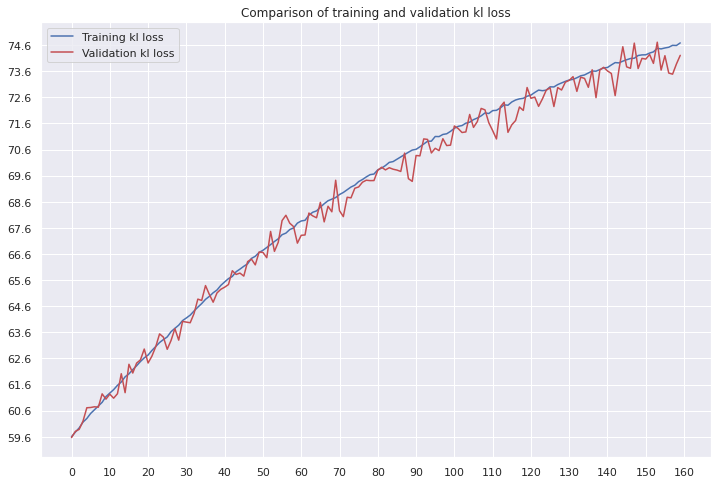

In [28]:
plt.figure(figsize=(12,8))
plt.plot(kl_loss[40:],'b')
plt.plot(val_kl_loss[40:],'r')
plt.legend(['Training kl loss', 'Validation kl loss'])
plt.xticks(range(0,len(val_kl_loss[40:])+10,10))
plt.yticks(np.arange(min(kl_loss[40:]),max(kl_loss[40:])))
plt.title('Comparison of training and validation kl loss');

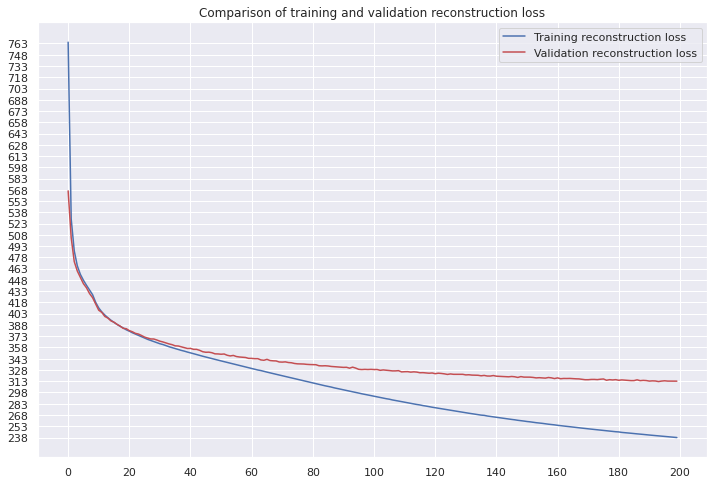

In [41]:
plt.figure(figsize=(12,8))
plt.plot(logx_loss,'b')
plt.plot(val_logx_loss,'r')
plt.legend(['Training reconstruction loss', 'Validation reconstruction loss'])
plt.xticks(range(0,len(logx_loss)+10,20))
plt.yticks(np.arange(min(logx_loss),max(logx_loss),15))
plt.title('Comparison of training and validation reconstruction loss');

# Having fun : )

## Generating random anime images

In [30]:
if model_std:
    x = L.Input((code_size,))
    decoded = decoder(x)
    decoded = vae.layers[-1](decoded)
    generator = tf.keras.Model(x,decoded)
else:
    generator = decoder

## Generating new images

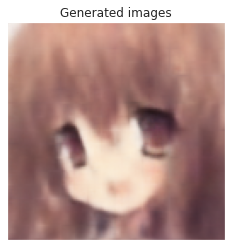

In [38]:
generated = generator.predict(np.random.normal(size=(1,code_size)))
plt.imshow(np.clip(generated[0],0,1))
plt.xticks([])
plt.yticks([])
plt.title('Generated images');

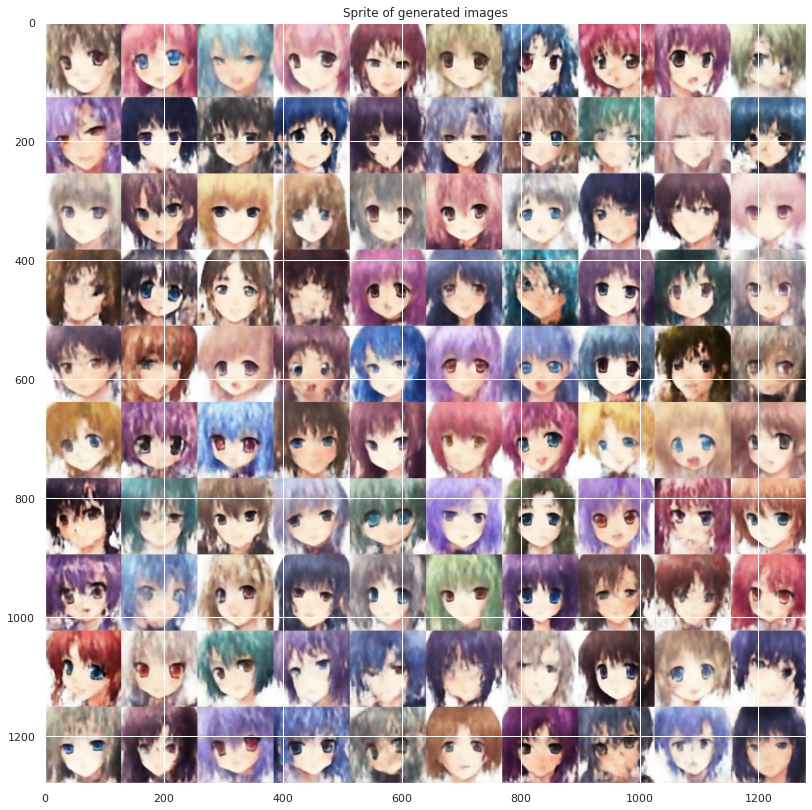

In [32]:
size = 128
n = 10  
figure = np.zeros((size * n, size * n,3))

for i in range(n):
    for j in range(n):
        z_sample = np.random.normal(size=(1,code_size))
        x_decoded = generator.predict(z_sample)
        anime_face = x_decoded[0].reshape(size, size,3)
        
        x = i * size
        y = j * size
        figure[x:x + size, y:y + size] = anime_face

plt.figure(figsize=(14, 14))
plt.title('Sprite of generated images')
plt.imshow(figure)
plt.show()

# Finding outliers using KL 

In [123]:
import tensorflow.keras.preprocessing.image  as preprocess_image

In [124]:
outliers = load_n_samples('../outliers',samples=3,workers=1,step=1)

In [125]:
outlier_detector = tf.keras.Model(inputs = vae.layers[0].input, outputs = [vae.layers[2].output,vae.layers[3].output])

In [126]:
def mean_KL(t_log_var,t_mean):
    return -0.5* np.mean(1. + t_log_var - np.square(t_mean) - np.exp(t_log_var), axis=-1)

In [129]:
def define_median_threshold(path='data/cropped/',samples=10000):
    data = load_n_samples(path,samples=samples)
    t_mean, t_log_var = outlier_detector.predict(data)
    kl_threshold = []
    for mean,var in zip(t_mean,t_log_var):  
        kl_threshold.append(mean_KL(t_log_var=var,t_mean=mean))
    kl_threshold = np.median(kl_threshold)
    return kl_threshold

In [130]:
kl_threshold = define_median_threshold()

In [131]:
def check_if_outlier(img,kl_threshold):
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.title('Image to investigate')
    t_mean, t_log_var = outlier_detector.predict(np.expand_dims(img,axis=0))
    kl  = mean_KL(t_log_var=t_log_var,t_mean=t_mean)[0]
    print('KL = ' + str(kl))
    if kl<kl_threshold:
        print('Image is not an outlier!')
    else:
        print('Image is an outlier!')
    plt.figure(figsize=(8,5))
    sns.distplot(norm.pdf(t_mean[0],t_log_var[0]))
    sns.distplot(np.random.normal(loc=0,scale=1,size=len(t_log_var[0])))
    plt.legend(['Image distribution','Normal distribution'])

KL = 0.8164321
Image is an outlier!


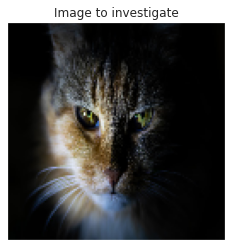

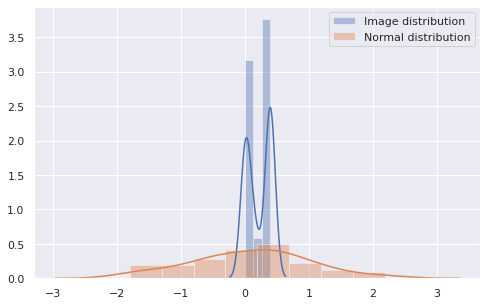

In [137]:
check_if_outlier(outliers[0],kl_threshold)

KL = 0.79162544
Image is an outlier!


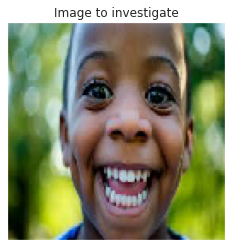

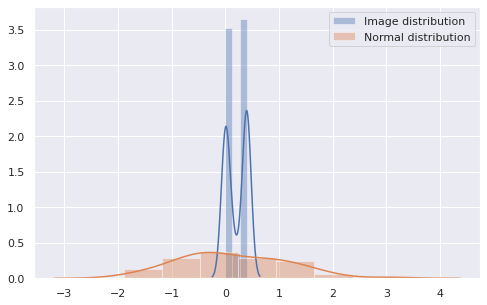

In [133]:
check_if_outlier(outliers[1],kl_threshold)

KL = 0.6429374
Image is not an outlier!


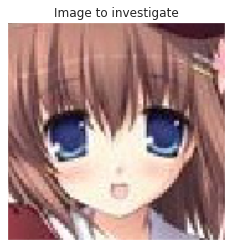

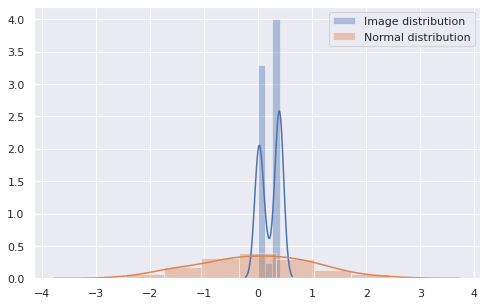

In [134]:
check_if_outlier(data[0],kl_threshold)

KL = 0.33887511
Image is not an outlier!


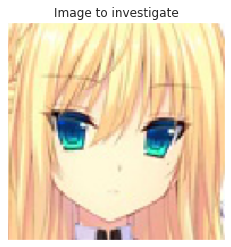

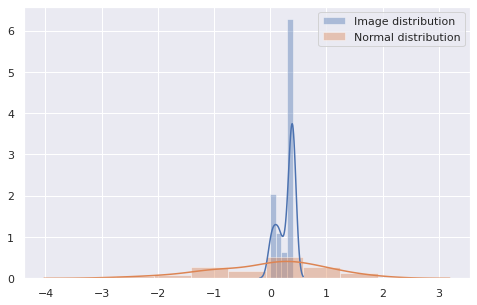

In [135]:
check_if_outlier(data[200],kl_threshold)